# Manuscript plots: stationary results

## Alexandra C Semposki

### Date: 18 February 2025

In [1]:
# import packages
%load_ext autoreload
%autoreload 2

import corner
import pickle
import sys
import arviz as az
sys.path.append('../src/')
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

from gp_utils import GaussianProcessRegressor2dNoise
from eos_utils import *
from tov_utils import *
from scripts import *
from pqcd_reworked import PQCD

import sys
sys.path.append('../../../TOV_Solver')
from TOV_class import TOVsolver

# set params for plotting
setup_rc_params()

# define saturation up here
n0 = 0.164

# color plotting assistance
orders = [0, 1, 2, 3]
order_labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed Model']
color_list = ['Reds', 'Blues','Purples', 'Oranges', 'Greens', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.7 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.5) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

In [2]:
# load NICER data
miller = np.loadtxt('../data/NICER_data/NICER+XMM_J0740_RM.txt')
miller_0030_2 = np.loadtxt('../data/NICER_data/J0030_2spot_RM.txt')
miller_0030_3 = np.loadtxt('../data/NICER_data/J0030_3spot_RM.txt')

# load NICER J0437 data
j0437 = np.loadtxt('../data/NICER_data/J0437_data/samples/J0437_3C50_BKG_AGN_hiMN_lowXPSI_wmrsamples.dat')

# load in the LIGO data from the folder
df_insens = pd.read_csv('../data/LIGO_data/EoS-insensitive_posterior_samples.dat', sep='\s+')
df_maxmass = pd.read_csv('../data/LIGO_data/Parametrized-EoS_maxmass_posterior_samples.dat', sep='\s+')

# convert to a dict
LIGO_insens = df_insens.to_dict('list')
LIGO_maxmass = df_maxmass.to_dict('list')

# LIGO data
x11 = np.asarray(LIGO_maxmass['Radius1_km'])
y11 = np.asarray(LIGO_maxmass['m1_source_frame_Msun'])
x22 = np.asarray(LIGO_maxmass['Radius2_km'])
y22 = np.asarray(LIGO_maxmass['m2_source_frame_Msun'])

## Stationary GP M-R curves

In [3]:
# compare 20n0 and 40n0 or compare spline vs. no spline (mean functions)
tov = TOVsolver(eos_filepath='../data/Paper_data/20n0_stationary_env.npz', tidal=False, moment=False)
tov2 = TOVsolver(eos_filepath='../data/Paper_data/40n0_stationary_env.npz', tidal=False, moment=False)

Woo it worked!
Woo it worked!


In [4]:
rad20, _, mass20 = tov.tov_routine(verbose=False, write_to_file=False)
rad40, _, mass40 = tov2.tov_routine(verbose=False, write_to_file=False)

Radius:  7.7008096112 Maximum mass:  1.2635065565687567 Central pressure:  867.6756497154504
Radius:  10.139873292799999 Maximum mass:  1.6776712848197097 Central pressure:  466.5364423805275
Radius:  12.5789369744 Maximum mass:  2.2454526729973887 Central pressure:  342.0973067434033
Radius:  6.6152922584 Maximum mass:  1.010478030434658 Central pressure:  1183.2958131473647
Radius:  9.3357863648 Maximum mass:  1.40315615948732 Central pressure:  466.5364423805275
Radius:  11.694441353599998 Maximum mass:  1.9539752354433066 Central pressure:  342.0973067434033


In [5]:
# get max mass arrays from each
max_rad20, _, max_mass20 = tov.max_arrays()
max_rad40, _, max_mass40 = tov2.max_arrays()

# get central densities of each envelope
cdens20 = tov.central_dens()
cdens40 = tov2.central_dens()

print(cdens20/n0)
print(cdens40/n0)

(3, 945)
(945, 3)
(3, 945)
(945, 3)
[12.91500109  8.42931689  6.25358836]
[17.32925234  9.46076809  6.86436919]


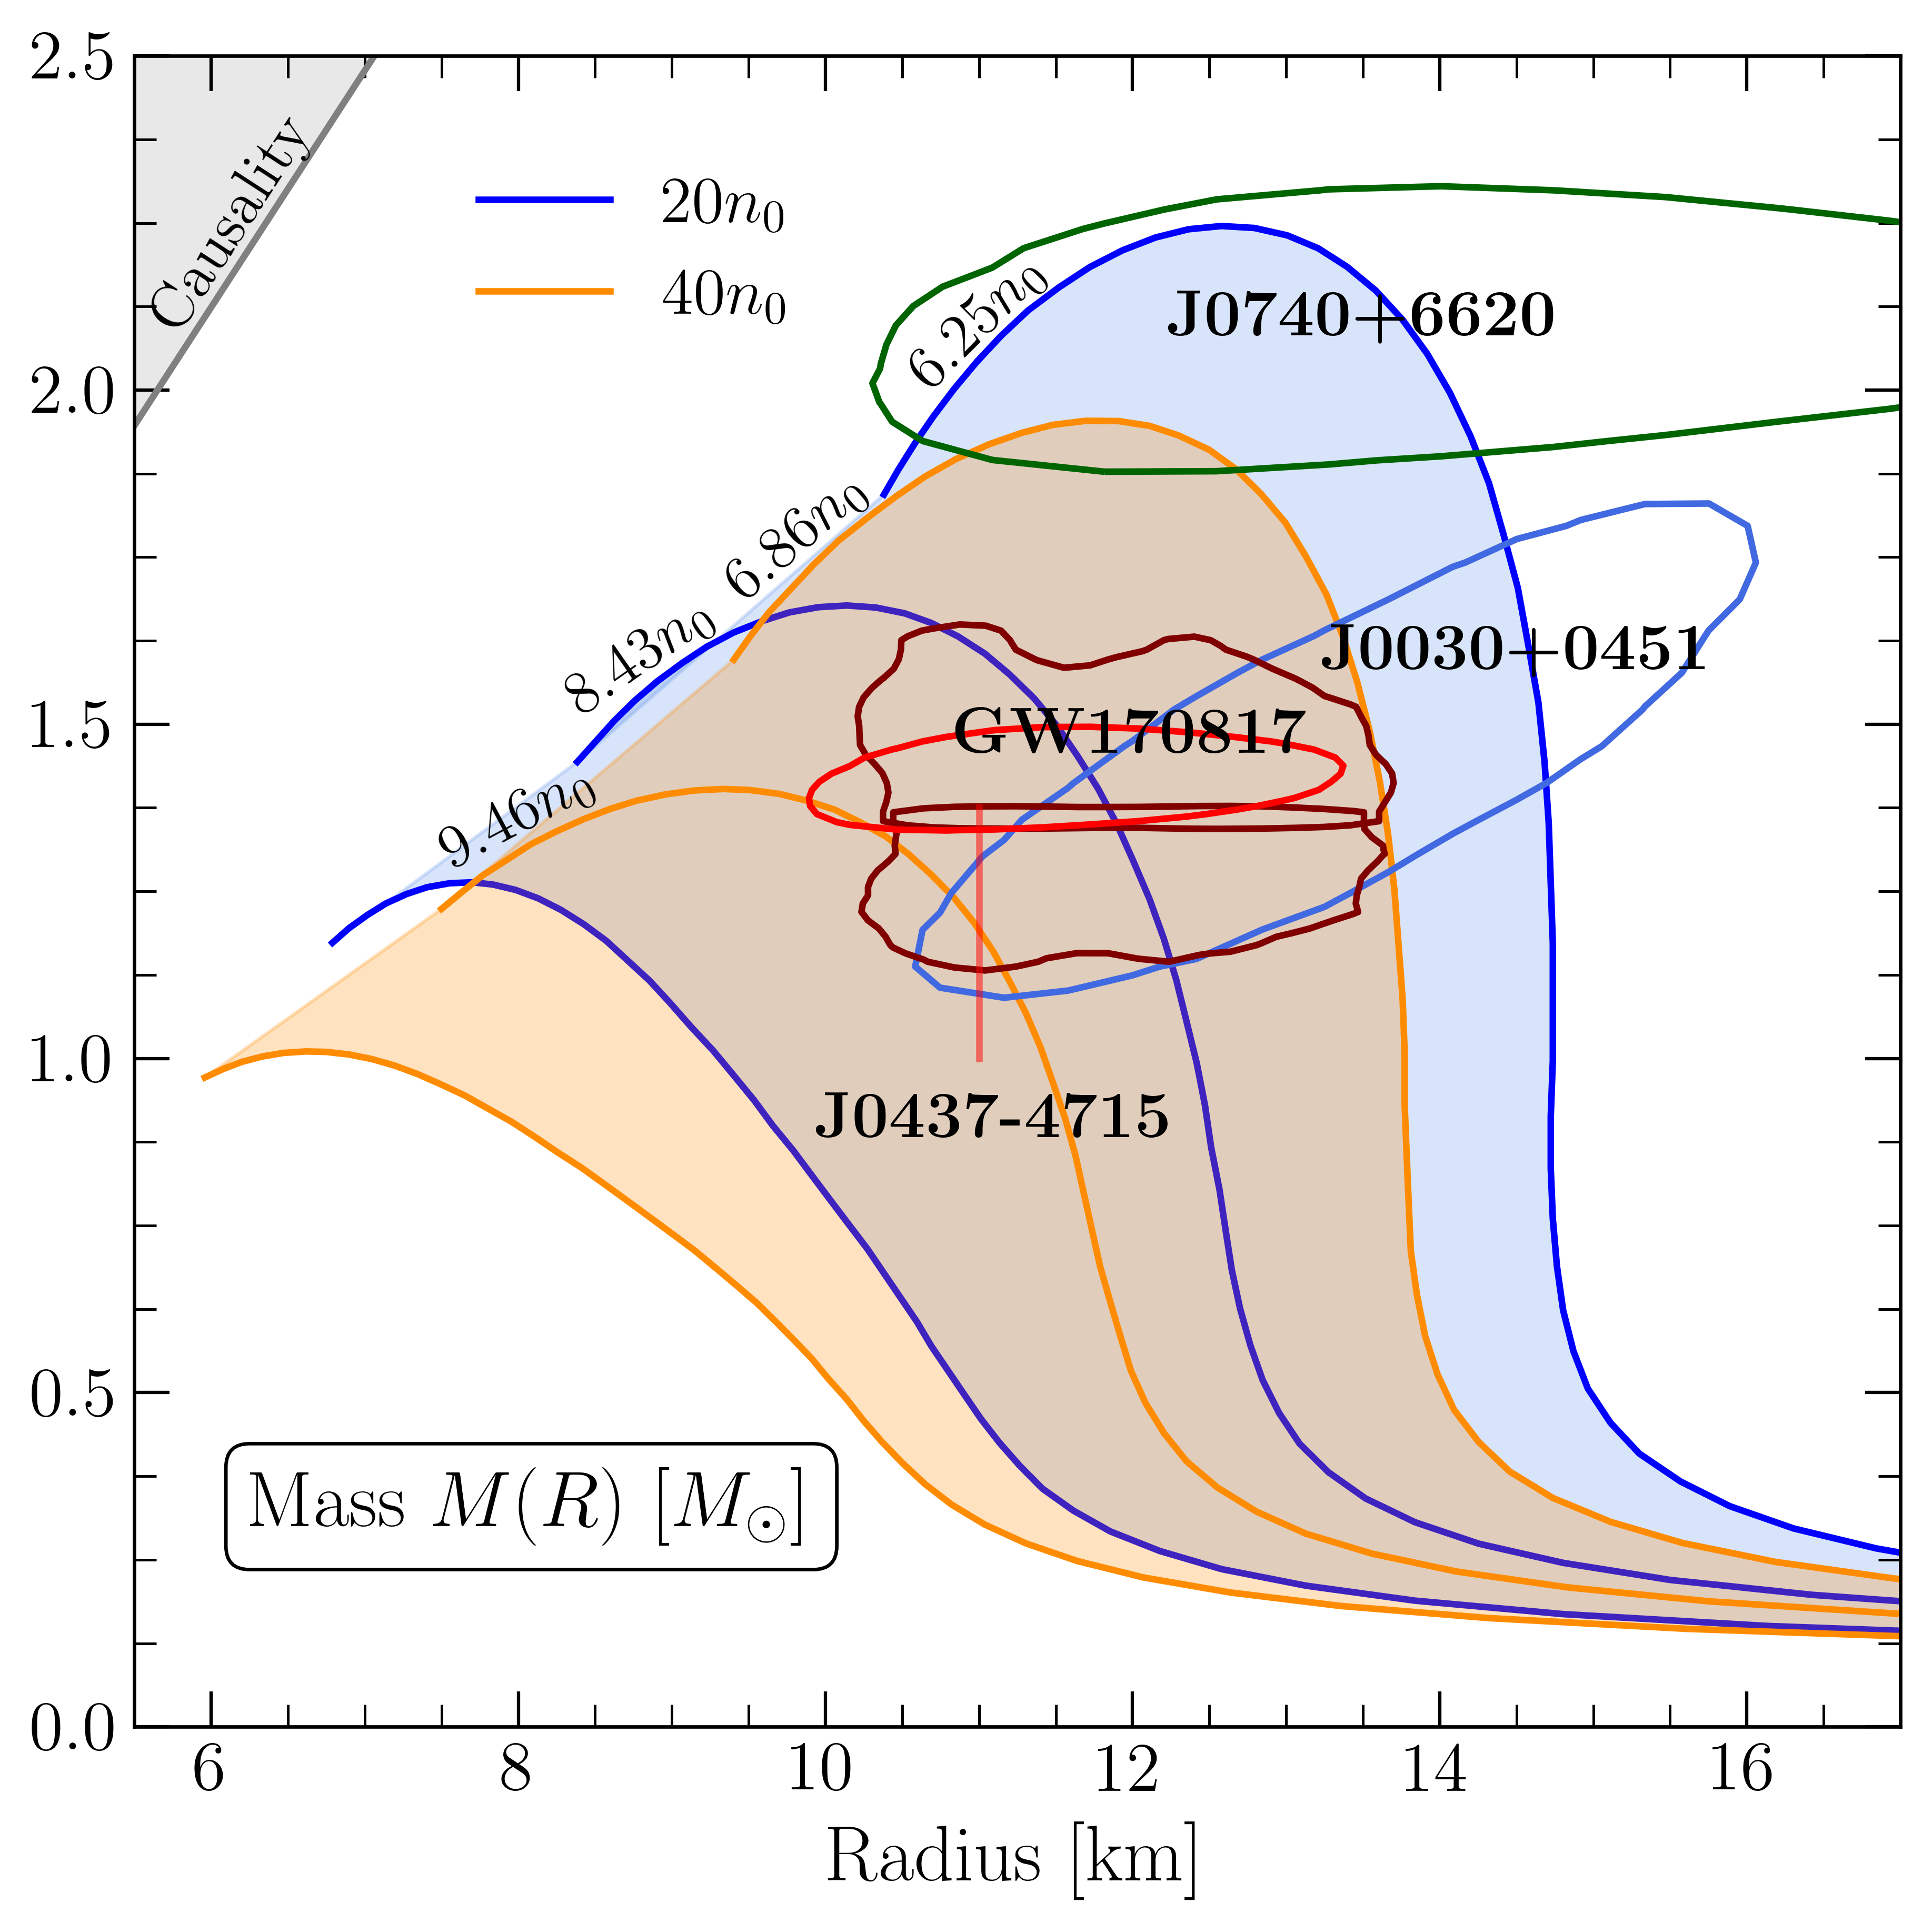

In [28]:
# plot the results
import matplotlib.patches as mpatches
from matplotlib.patches import Polygon

import sys
sys.path.append('../src')
from scripts import *
setup_rc_params()

# plot the results including the samples and the overall mean, std_dev
fig = plt.figure(figsize=(6,6), dpi=600)
ax = plt.axes()

# 20n0
vertices = [(x, y1_val) for x, y1_val in zip(rad20[:,1], mass20[:,1])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(rad20[:,2]), reversed(mass20[:,2]))]
vertices2 = [(x, y1_val) for x, y1_val in zip(rad20[:,0], mass20[:,0])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(rad20[:,1]), reversed(mass20[:,1]))]

# 40n0
vertices40 = [(x, y1_val) for x, y1_val in zip(rad40[:,1], mass40[:,1])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(rad40[:,2]), reversed(mass40[:,2]))]
vertices402 = [(x, y1_val) for x, y1_val in zip(rad40[:,0], mass40[:,0])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(rad40[:,1]), reversed(mass40[:,1]))]

polygon = Polygon(vertices, closed=True, color="cornflowerblue", alpha=0.25, zorder=-10)
polygon2 = Polygon(vertices2, closed=True, color="cornflowerblue", alpha=0.25, zorder=-10)
plt.gca().add_patch(polygon)
plt.gca().add_patch(polygon2)

# means
ax.plot(rad20, mass20, color='blue', label=r'$20n_{0}$', zorder=-9)

polygon40 = Polygon(vertices40, closed=True, color="darkorange", alpha=0.25, zorder=-5)
polygon402 = Polygon(vertices402, closed=True, color="darkorange", alpha=0.25, zorder=-5)
plt.gca().add_patch(polygon40)
plt.gca().add_patch(polygon402)

# means
ax.plot(rad40, mass40, color='darkorange', label=r'$40n_{0}$', zorder=-4)

handles, labels = plt.gca().get_legend_handles_labels()

# remove duplicates by converting to a dictionary
unique = dict(zip(labels, handles))
legend = ax.legend(unique.values(), unique.keys(), fontsize=15, frameon=False, bbox_to_anchor=[0.15, 0.975])

# NICER and LIGO contours
corner.hist2d(miller[:,0], miller[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.8, ax=ax, color='darkgreen', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=False)
corner.hist2d(miller_0030_2[:,0], miller_0030_2[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.8, ax=ax, color='royalblue', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=False)
corner.hist2d(x11, y11, bins=30, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=1.1, ax=ax, color='maroon', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=False)
corner.hist2d(x22, y22, bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.9, ax=ax, color='maroon', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=False)
corner.hist2d(j0437[:,2], j0437[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=j0437[:,0], \
              levels=[0.9], smooth=0.8, ax=ax, color='red', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=False)
    
# labels for LIGO and NICER data
ax.text(13.5, 2.15, r'$\textbf{J0740+6620}$', zorder=100, ha='center', va='top', fontsize=15)
ax.text(14.5, 1.65, r'$\textbf{J0030+0451}$', zorder=100, ha='center', va='top', fontsize=15)

# # GW 190814
# fake_linspace = np.linspace(5.5, 17.0, 100)
# gw_lower = 2.51*np.ones(len(fake_linspace))
# gw_upper = 2.67*np.ones(len(fake_linspace))
# ax.fill_between(fake_linspace, gw_lower, gw_upper, alpha=0.25, color='grey', hatch='/')
# ax.axhline(y=2.51, color='lightgrey')
# ax.axhline(y=2.67, color='lightgrey')
# ax.text(11.5, 2.635, r'$\textbf{GW190814}$', ha='center', va='top', fontsize=16)
ax.text(12.0, 1.525, r'$\textbf{GW170817}$', ha='center', va='top', fontsize=15, zorder=10)
ax.axvline(x=11.0, ymin=0.4, ymax=0.55, color='red', alpha=0.5)
ax.text(11.1, 0.95, r'$\textbf{J0437-4715}$', ha='center', va='top', fontsize=15)

# adding labels for central densities of the top 2 curves
ax.text(8.0, 1.36, r'{:.2f}$n_0$'.format(cdens40[1]/n0), rotation=28, va='center', \
        ha='center', fontsize=14)
ax.text(9.82, 1.78, r'{:.2f}$n_0$'.format(cdens40[2]/n0), rotation=41, va='center', \
        ha='center', fontsize=14)

ax.text(8.8, 1.6, r'{:.2f}$n_0$'.format(cdens20[1]/n0), rotation=35, va='center', \
        ha='center', fontsize=14)
ax.text(11.0, 2.1, r'{:.2f}$n_0$'.format(cdens20[2]/n0), rotation=45, va='center', \
        ha='center', fontsize=14)

# causality limit
radlim = np.linspace(5.0, 20.0, 100)
ax.plot(radlim, 0.354*radlim, color='grey')
ax.fill_between(radlim, 0.354*radlim, 3.0, color='lightgrey', alpha=0.5)
ax.text(6.15, 2.25, r'Causality', rotation=57, va='center', \
        ha='center', fontsize=14)

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.125))
ax.tick_params(axis='both', which='major', labelsize=16, right=True, top=True, length=8)
ax.tick_params(axis='both', which='minor', labelsize=16, right=True, top=True, length=5)
ax.set_xlim(5.5, 17.0)
ax.set_ylim(0.0,2.5)
ax.set_xlabel(r'Radius [km]', fontsize=18)
ax.text(6.25, 0.30, r'Mass $M(R)$ $[M_\odot]$', fontsize=18, bbox=dict(facecolor='w', boxstyle='round'))
fig.savefig('../figures/ANM_Figures/mr_stationary_comparison_20_40.pdf')
plt.show()

## Scaled pressure and speed of sound squared

This will be a two panel plot.

In [179]:
# data imports
pressure_20 = np.load('../data/NSM_data/gp_pressure_20_NSM.npz')
pressure_40 = np.load('../data/NSM_data/gp_pressure_40_NSM.npz')
pqcd_20 = np.load('../data/NSM_data/pressure_pqcd_cut_20_NSM.npz')
pqcd_40 = np.load('../data/NSM_data/pressure_pqcd_cut_40_NSM.npz')
xeft = np.load('../data/NSM_data/chiral_nsm_n3lo.npz')
cs2_20 = np.load('../data/Paper_data/cs2_data_20n0_stationary.npz')
cs2_40 = np.load('../data/Paper_data/cs2_data_40n0_stationary.npz')

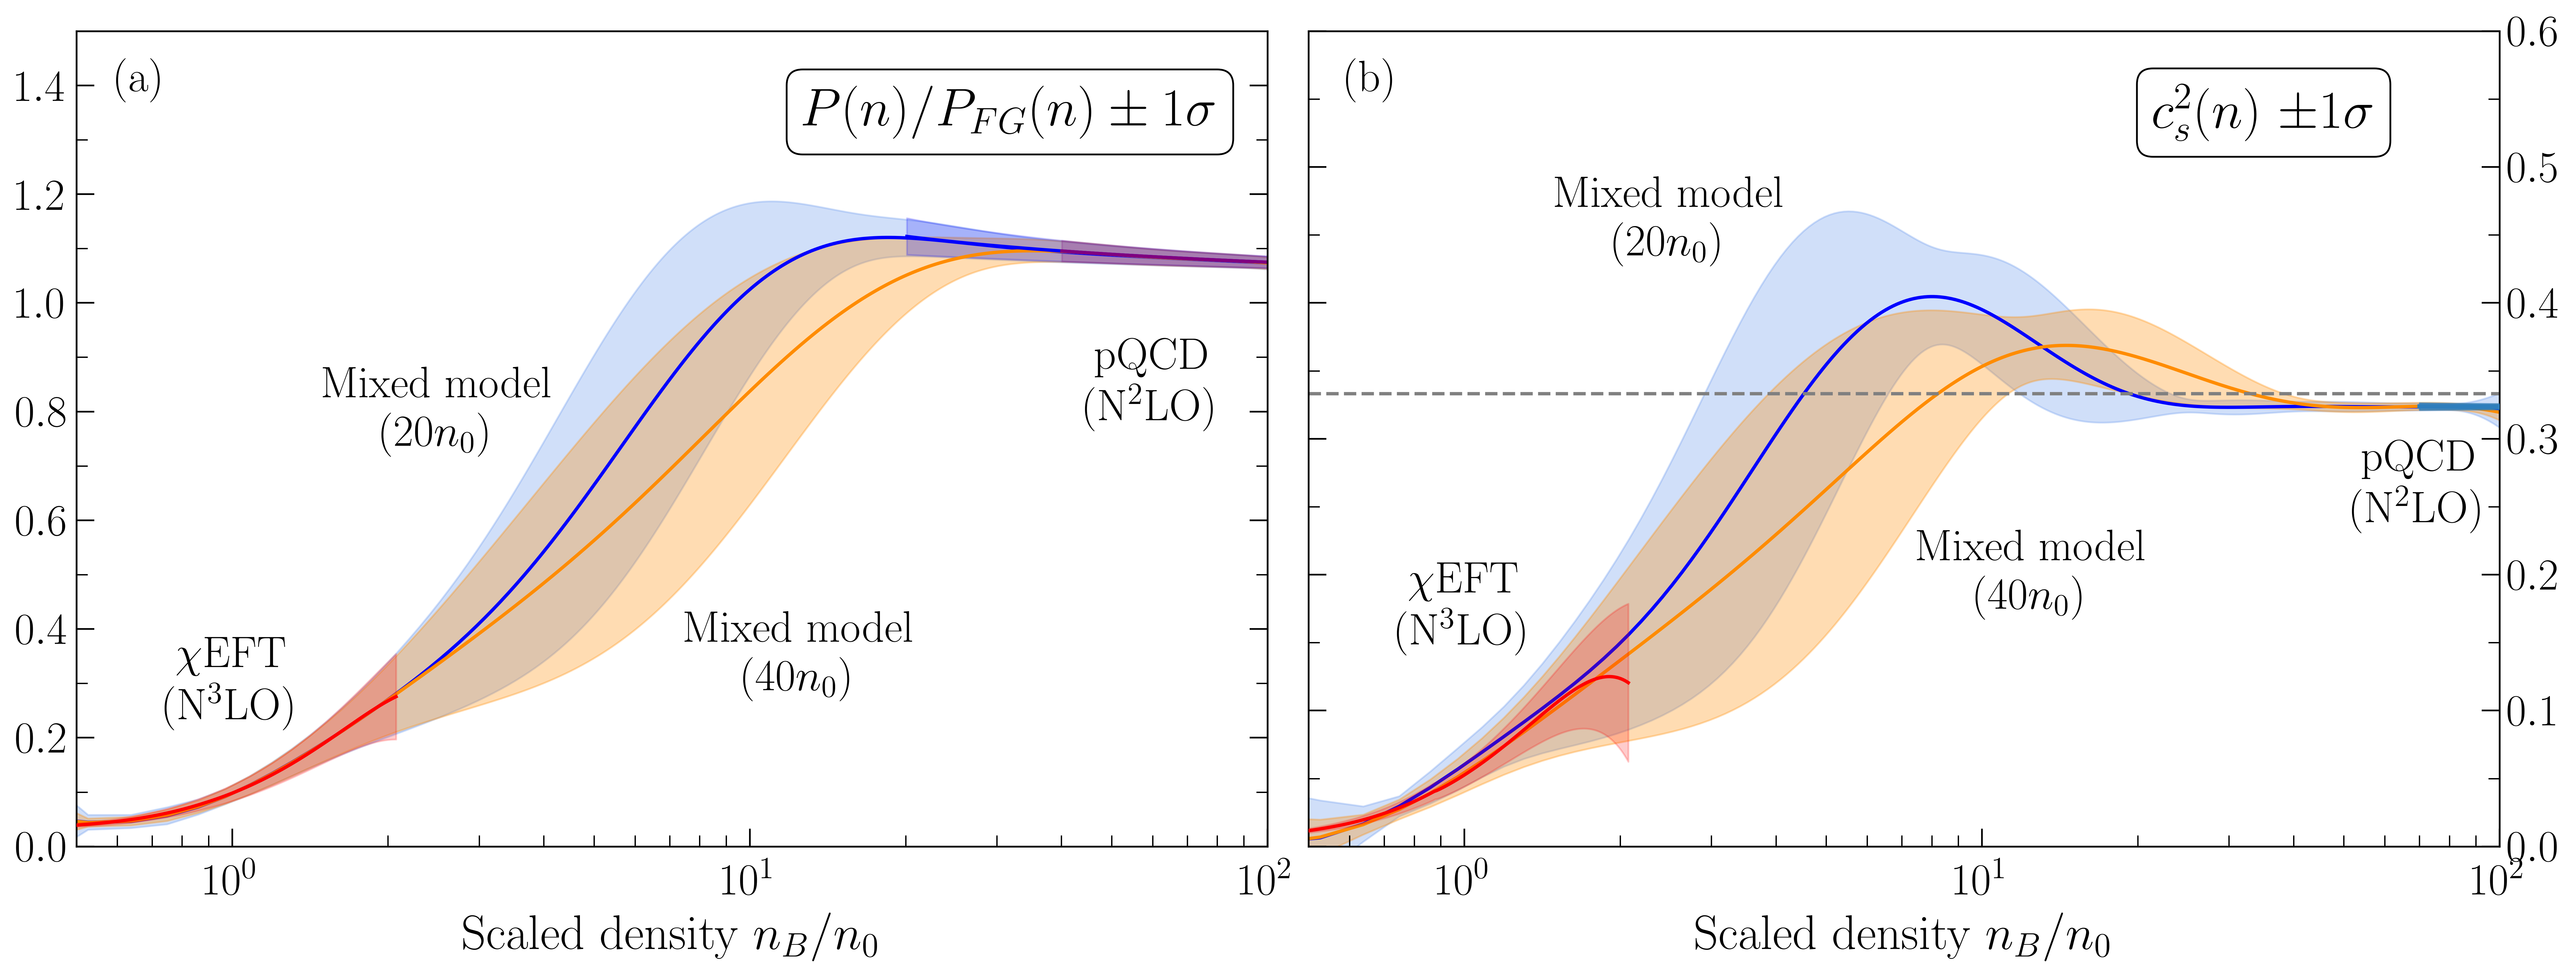

In [186]:
# set up the plot requirements
fig, ax = plt.subplots(1, 2, figsize=(16,6), dpi=600, sharex='col')

# first panel (pressure)
ax[0].set_xlim(0.5, 100.0)
ax[0].set_ylim(0.0,1.5)
ax[0].tick_params(axis='x', which='major', labelsize=20, right=True, pad=8, length=8)
ax[0].tick_params(axis='x', which='minor', labelsize=20, right=True, pad=8, length=5)
ax[0].tick_params(axis='y', which='major', labelsize=20, right=True, length=8)
ax[0].tick_params(axis='y', which='minor', labelsize=20, right=True, length=5)
ax[0].xaxis.set_major_locator(MultipleLocator(10))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.1))
ax[0].text(
    80.0,1.4, r'$P(n)/P_{FG}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[0].text(0.75, 1.45, r'(a)', ha='right', va='top', fontsize=20)
ax[0].set_xlabel(r'Scaled density $n_B/n_{0}$', fontsize=22)
ax[0].set_xscale('log')

ax[1].set_xlim(0.5, 100.)
ax[1].set_ylim(0.0,0.6)
ax[1].xaxis.set_major_locator(MultipleLocator(10))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[1].tick_params(axis='y', which='major', labelsize=20, labelleft=False, labelright=True, \
                  right=True, length=8)
ax[1].tick_params(axis='y', which='minor', labelsize=20, labelleft=False, labelright=True, \
                  right=True, length=5)
ax[1].tick_params(axis='x', which='major', labelsize=20, labelleft=False, labelright=True, \
                  right=True, pad=8, length=8)
ax[1].tick_params(axis='x', which='minor', labelsize=20, labelleft=False, labelright=True, \
                  right=True, pad=8, length=5)
ax[1].text(0.75, 0.58, r'(b)', ha='right', va='top', fontsize=20)
ax[1].set_xlabel(r'Scaled density $n_B/n_{0}$', fontsize=22)
ax[1].set_xscale('log')

# pressure data
ax[0].plot(pressure_20['dens']/n0, pressure_20['mean'], color='blue')
ax[0].fill_between(pressure_20['dens']/n0, pressure_20['mean']-pressure_20['std'], \
                   pressure_20['mean']+pressure_20['std'], color='cornflowerblue', alpha=0.3)

ax[0].plot(pressure_40['dens']/n0, pressure_40['mean'], color='darkorange')
ax[0].fill_between(pressure_40['dens']/n0, pressure_40['mean']-pressure_40['std'], \
                   pressure_40['mean']+pressure_40['std'], color='darkorange', alpha=0.3)

ax[0].plot(pqcd_20['dens']/n0, pqcd_20['mean'], color='blue', label=r'pQCD (N$^2$LO) ($20n_0$)')
ax[0].fill_between(pqcd_20['dens']/n0, pqcd_20['mean']-pqcd_20['std'], pqcd_20['mean']+pqcd_20['std'], \
                 alpha=0.2, color='blue')
ax[0].plot(pqcd_40['dens']/n0, pqcd_40['mean'], color='purple', label=r'pQCD (N$^2$LO) ($40n_0$)')
ax[0].fill_between(pqcd_40['dens']/n0, pqcd_40['mean']-pqcd_40['std'], pqcd_40['mean']+pqcd_40['std'], \
                 alpha=0.2, color='purple')

ax[0].plot(xeft['density']/n0, xeft['mean'], color='red', zorder=10)
ax[0].fill_between(xeft['density']/n0, xeft['mean']-xeft['std_dev'], xeft['mean']+xeft['std_dev'], \
                   color='red', alpha=0.2, zorder=10)

ax[0].text(60.0, 0.85, r'''pQCD
(N$^2$LO)''', va='center', ha='center', fontsize=20)
ax[0].text(1.0, 0.30, r'''$\chi$EFT
(N$^3$LO)''', va='center', ha='center', fontsize=20)
ax[0].text(2.5, 0.8, r'''Mixed model 
($20n_0$)''', va='center', ha='center', fontsize=20)
ax[0].text(12.5, 0.35, r'''Mixed model 
($40n_0$)''', va='center', ha='center', fontsize=20)

# speed of sound data
cs2_chiral = np.load('../data/NSM_data/cs2_chiral_NSM.npz')
cs2_pqcd = np.load('../data/eos_data/pqcd_cs2_NSM.npz')   # only have one of the two (40, need 20)

# speed of sound plotting
ax[1].plot(cs2_20['dens']/n0, cs2_20['mean'], color='blue')
ax[1].fill_between(cs2_20['dens']/n0, cs2_20['mean']-cs2_20['std'], \
                 cs2_20['mean']+cs2_20['std'], color='cornflowerblue', alpha=0.3)

ax[1].plot(cs2_40['dens']/n0, cs2_40['mean'], color='darkorange')
ax[1].fill_between(cs2_40['dens']/n0, cs2_40['mean']-cs2_40['std'], \
                 cs2_40['mean']+cs2_40['std'], color='darkorange', alpha=0.3)

ax[1].plot(cs2_pqcd['density']/n0, cs2_pqcd['mean'], color=colors[1], linewidth=2, \
         zorder=10)
ax[1].fill_between(cs2_pqcd['density']/n0, cs2_pqcd['lower'], cs2_pqcd['upper'], \
                 facecolor=colors[1], edgecolor=colors[1], alpha=0.7, zorder=10)

ax[1].plot(cs2_chiral['density']/n0, cs2_chiral['mean'], color='red', zorder=10)
ax[1].fill_between(cs2_chiral['density']/n0, cs2_chiral['mean']-cs2_chiral['std'], \
                 cs2_chiral['mean']+cs2_chiral['std'], alpha=0.2, \
                color='red', zorder=10)

ax[1].text(35.0, 0.54, r'$c_{s}^{2}(n)$ $\pm 1\sigma$', va='center', ha='center', \
         fontsize=24, bbox=dict(facecolor='w', boxstyle='round'))
ax[1].text(70.0, 0.265, r'''pQCD
(N$^2$LO)''', va='center', ha='center', fontsize=20)
ax[1].text(1.0, 0.175, r'''$\chi$EFT
(N$^3$LO)''', va='center', ha='center', fontsize=20)
ax[1].text(2.5, 0.46, r'''Mixed model 
($20n_0$)''', va='center', ha='center', fontsize=20)
ax[1].text(12.5, 0.2, r'''Mixed model 
($40n_0$)''', va='center', ha='center', fontsize=20)

# speed of sound conformal limit 
ax[1].axhline(y=(1.0/3.0), color='grey', linestyle='dashed')  # conformal limit

# causality line
dens_cs2 = np.linspace(0.0, 16.4, 100)
fig.savefig('../figures/ANM_Figures/pressure_cs2_stationary_20_40.pdf', bbox_inches='tight')
plt.show()